In [1]:
import os
import time
import datetime
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPool2D, Dropout,MaxPooling2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import cifar10

from sklearn.utils import check_random_state
#from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [2]:
from tensorflow.keras.datasets import cifar10

trainset_size = 50000
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
            'dog', 'frog', 'horse', 'ship', 'truck']

def get_dataset():
  (X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()
  # summarize loaded dataset
  print('Cifer Train: X=%s, y=%s' % (X_train_full.shape, y_train_full.shape))
  print('Cifer Test: X=%s, y=%s' % (X_test.shape, y_test.shape))
  return (X_train_full, y_train_full, X_test, y_test)

class Normalize(object):
    
    def normalize(self, X, y):
        X = X.astype('float32')/255.
        y = y.astype('int32')
        return (X, y) 
    
    def inverse(self, X, y):
        X = X.astype('float32')*255.
        y = y.astype('int32')
        return (X, y) 

In [3]:
from sklearn.utils import check_random_state
import numpy as np

def get_k_random_samples(trainset_size, initial_labeled_samples, X_train_full,
                         y_train_full):
    random_state = check_random_state(0)
    permutation = np.random.choice(trainset_size, initial_labeled_samples, replace=False)

    print ('Initial random chosen samples', permutation.shape)
    #, permutation)
    X_train = X_train_full[permutation]
    y_train = y_train_full[permutation]
    #X_train = X_train.reshape((X_train.shape[0], -1))
    #print('X train shape :',X_train.shape)
    y_train_bin = y_train.reshape(1000,)
    bin_count = np.bincount(y_train_bin.astype('int64'))
    unique = np.unique(y_train)
    print ( 'initial train set:', X_train.shape, y_train.shape,
        '\nlabels count:', bin_count, unique,
        )
    return (permutation, X_train, y_train)

In [4]:
import numpy as np
from scipy.stats import entropy
from sklearn.utils import check_random_state

labels= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

class BaseSelectionFunction(object):

    def __init__(self):
        pass

    def select(self):
        pass


class RandomSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        random_state = check_random_state(0)
        selection = np.random.choice(probas_val.shape[0], initial_labeled_samples, replace=False)
        return selection

class KL_QBC(BaseSelectionFunction):
    def average_KL_divergence(probas_val, probas_val2, X_train, y_train, X_seedset, y_seedset):
      preds = []
      preds.append(probas_val)
      preds.append(probas_val2)
      # print(probas_val.shape)
      # print(probas_val2.shape)

      #stack so tar ka array list ko numpy arrary change tar
      consensus = np.mean(np.stack(preds), axis=0)
      print('consensus :',consensus)
      divergence = []
      for y_out in preds:
        divergence.append(entropy(consensus.T, y_out.T))
      #print('divergence values :', len(divergence),divergence)

      result = np.apply_along_axis(np.mean, 0, np.stack(divergence))
      #print('result after np along axis the divergence :', result.shape, result)
      # np.apply_along_axis(np.mean, 0, np.stack(divergence))

      #argsort Returns the indices that would sort an array.
      #argsort sort in increasing order but if -result then it sort in decreasing order.
      rankings = np.argsort(-result)[:1000]
      rankings
      #print(result[28324], result[13958], result[44722])

    #   X_train = np.concatenate((X_train, X_seedset[rankings, :]))
    #   y_train = np.concatenate((y_train, y_seedset[rankings]))

    #   X_seedset = np.delete(X_seedset, rankings, axis=0)
    #   y_seedset = np.delete(y_seedset, rankings, axis=0)

      #print("New train and seedset after ",X_train.shape, X_seedset.shape)
      return rankings

class vote_entropy_QBC():
    def vote_entropy(probas_val, probas_val2, X_train, y_train, X_seedset, y_seedset):
      #vote entropy
      preds = []
      #print(probas_val1.shape)
      #print(probas_val2.shape)
      probas_val_not_cat = np.argmax(probas_val,axis=1)
      #print(probas_val_not_cat[0:20])
      probas_val2_not_cat = np.argmax(probas_val2, axis=-1)
      #print(probas_val2_not_cat[0:20])

      preds.append(np.eye(len(labels))[probas_val_not_cat])
      preds.append(np.eye(len(labels))[probas_val2_not_cat])
      #np.round(probas_val)

      # C = no of models
      votes = np.apply_along_axis(np.sum, 0, np.stack(preds)) / 2
      #print('votes :', votes.shape, votes)
      results = np.apply_along_axis(entropy, 1, votes)

      rankings = np.argsort(-results)[:1000]
      rankings

      #print(result[28324], result[13958], result[44722])
      #print(X_train.shape, X_seedset.shape)

    #   X_train = np.concatenate((X_train, X_seedset[rankings, :]))
    #   y_train = np.concatenate((y_train, y_seedset[rankings]))
    #   X_seedset = np.delete(X_seedset, rankings, axis=0)
    #   y_seedset = np.delete(y_seedset, rankings, axis=0)

      #print(X_augmented.shape, X_seedset.shape)
      return rankings

In [5]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.callbacks import ModelCheckpoint
#%load_ext tensorboard

def train_model1( X_train_org, y_train_org,X_seedset, X_test, y_test, labels):

        X_train, X_val, y_train, y_val = train_test_split( X_train_org, y_train_org, test_size=0.3, random_state=42)
        print('X_train :', X_train.shape)
        print('y train :', y_train.shape)
        print('X val :', X_val.shape)
        print('y val:', y_val.shape)

        # filepath = 'modelfiles/model_1.h5'
        # cp = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

        # log_dir = "logs/fit/model1" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        model = Sequential()

        model.add(Conv2D(filters=32, kernel_size=(4, 4), input_shape=(32, 32, 3), activation='relu', padding='same'))
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(filters=64, kernel_size=(4, 4), activation='relu', padding='same'))
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same'))
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(10, activation='softmax'))

        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        early_stop = EarlyStopping(monitor='val_loss', patience=2)

        r = model.fit(X_train, y_train,  epochs=50, validation_data=(X_val, y_val))#, callbacks=[cp, tensorboard_callback])
        
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1)
        plt.plot(r.history['loss'], label='Loss')
        plt.plot(r.history['val_loss'], label='val_Loss')
        plt.legend()
        plt.title('Loss evolution')
        plt.savefig('figs/model1_loss'+str(iterations)+'.png')

        plt.subplot(2, 2, 2)
        plt.plot(r.history['accuracy'], label='accuracy')
        plt.plot(r.history['val_accuracy'], label='val_accuracy')
        plt.legend()
        plt.title('Accuracy evolution')
        plt.savefig('figs/model1_acc'+str(iterations)+'.png')

        # Evaluate the model on the test data using `evaluate`
        print('\n# Evaluate on test data')
        results = model.evaluate(X_test, y_test, batch_size=128)
        print('test loss, test acc:', results)
        
        test_y_predicted = model.predict(X_test)
        test_y_predicted = np.argmax(test_y_predicted, axis=1)
        val_y_predicted  = model.predict(X_val)
        val_y_predicted = np.argmax(val_y_predicted, axis=1)
        cm = confusion_matrix(y_test, test_y_predicted)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        fig, ax = plt.subplots(figsize=(10, 10))
        disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')
        plt.show()
        plt.savefig('figs/model1_cm'+str(iterations)+'.png')

        probas_val = model.predict(X_seedset)
        #print ('probabilities:', probas_val.shape, '\n', np.argmax(probas_val, axis=1))

        recordmodel1.loc[iterations] = [X_train_org.shape[0], X_seedset.shape[0], r.history['accuracy'][-1], r.history['loss'][-1],r.history['val_accuracy'][-1],r.history['val_loss'][1], results[1], results[0]]

        return probas_val

Using TensorFlow backend.


In [6]:
def train_model2( X_train_org, y_train_org,X_seedset, X_test, y_test, labels):

        X_train, X_val, y_train, y_val = train_test_split( X_train_org, y_train_org, test_size=0.3, random_state=42)
        print('X_train :', X_train.shape)
        print('y train :', y_train.shape)
        print('X val :', X_val.shape)
        print('y val:', y_val.shape)

        # filepath = 'modelfiles/model_2.h5'
        # cp = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

        # log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        model = tf.keras.Sequential([
            
            Conv2D(48, kernel_size=(3,3), activation='relu', padding='same', input_shape=(32,32,3)),
            MaxPooling2D((2,2),(2,2)),
            
            Conv2D(96, kernel_size=(3,3), activation='relu', padding='same'),
            MaxPooling2D((2,2),(2,2)),
            
            Conv2D(192,kernel_size=(3,3), activation='relu', padding='same'),
            Conv2D(192,kernel_size=(3,3), activation='relu', padding='same'),
            MaxPooling2D((2,2),(2,2)),
            
            Conv2D(256,kernel_size=(3,3), activation='relu', padding='same'),
            MaxPooling2D((2,2),(2,2)),

            Flatten(),
            Dense(512, activation='tanh'),
            Dense(256, activation='tanh'),
            Dense(10, name='logits'),
            Activation('softmax')
        ])

        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        early_stop = EarlyStopping(monitor='val_loss', patience=2)

        r = model.fit(X_train, y_train,  epochs=50, validation_data=(X_val, y_val))#, callbacks=[cp, tensorboard_callback])

        plt.figure(figsize=(12, 8))

        plt.subplot(2, 2, 1)
        plt.plot(r.history['loss'], label='Loss')
        plt.plot(r.history['val_loss'], label='val_Loss')
        plt.legend()
        plt.title('Loss evolution')
        plt.savefig('figs/model1_loss'+str(iterations)+'.png')

        plt.subplot(2, 2, 2)
        plt.plot(r.history['accuracy'], label='accuracy')
        plt.plot(r.history['val_accuracy'], label='val_accuracy')
        plt.legend()
        plt.title('Accuracy evolution')
        plt.savefig('figs/model1_acc'+str(iterations)+'.png')

        # Evaluate the model on the test data using `evaluate`
        print('\n# Evaluate on test data')
        results = model.evaluate(X_test, y_test, batch_size=128)
        print('test loss, test acc:', results)
        
        test_y_predicted = model.predict(X_test)
        test_y_predicted = np.argmax(test_y_predicted, axis=1)
        val_y_predicted  = model.predict(X_val)
        val_y_predicted = np.argmax(val_y_predicted, axis=1)
        cm = confusion_matrix(y_test, test_y_predicted)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        fig, ax = plt.subplots(figsize=(10, 10))
        disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')
        plt.show()
        plt.savefig('figs/model1_cm'+str(iterations)+'.png')

        probas_val = model.predict(X_seedset)
        #print ('probabilities:', probas_val.shape, '\n', np.argmax(probas_val, axis=1))

        recordmodel2.loc[iterations] = [X_train_org.shape[0], X_seedset.shape[0], r.history['accuracy'][-1], r.history['loss'][-1],r.history['val_accuracy'][-1],r.history['val_loss'][1], results[1], results[0]]

        return probas_val

In [7]:
def plot_fun(X, y):
  #X_train, X_test = X_train.astype('int32')*255. , X_test.astype('int8')*255.

  # Define the labels of the dataset
  labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
            'dog', 'frog', 'horse', 'ship', 'truck']

  # Let's view more images in a grid format
  # Define the dimensions of the plot grid 
  W_grid = 10
  L_grid = 10

  # fig, axes = plt.subplots(L_grid, W_grid)
  # subplot return the figure object and axes object
  # we can use the axes object to plot specific figures at various locations

  fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

  axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

  n_train = len(X) # get the length of the train dataset

  # Select a random number from 0 to n_train
  for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

      # Select a random number
      index = np.random.randint(0, n_train)
      # read and display an image with the selected index    
      axes[i].imshow(X[index,1:])
      label_index = int(y[index])
      axes[i].set_title(labels[label_index], fontsize = 8)
      axes[i].axis('off')

  plt.subplots_adjust(hspace=0.4)

Cifer Train: X=(50000, 32, 32, 3), y=(50000, 1)
Cifer Test: X=(10000, 32, 32, 3), y=(10000, 1)
Initial random chosen samples (1000,)
initial train set: (1000, 32, 32, 3) (1000, 1) 
labels count: [ 97  95 108 114  82 107  88  98 112  99] [0 1 2 3 4 5 6 7 8 9]
Train set size X : (1000, 32, 32, 3)
(1000, 1)
Seed set (Pool) : (49000, 32, 32, 3) (49000, 1)
X_train : (700, 32, 32, 3)
y train : (700, 1)
X val : (300, 32, 32, 3)
y val: (300, 1)
Epoch 1/50
22/22 [==============================] - 1s 55ms/step - loss: 2.3177 - accuracy: 0.1300 - val_loss: 2.3036 - val_accuracy: 0.0933
Epoch 2/50
22/22 [==============================] - 1s 48ms/step - loss: 2.2716 - accuracy: 0.1557 - val_loss: 2.2744 - val_accuracy: 0.1267
Epoch 3/50
22/22 [==============================] - 1s 45ms/step - loss: 2.1615 - accuracy: 0.1914 - val_loss: 2.1467 - val_accuracy: 0.2000
Epoch 4/50
22/22 [==============================] - 1s 46ms/step - loss: 2.0790 - accuracy: 0.2257 - val_loss: 2.2142 - val_accuracy: 0.

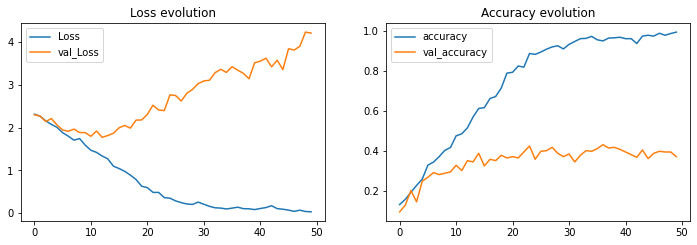

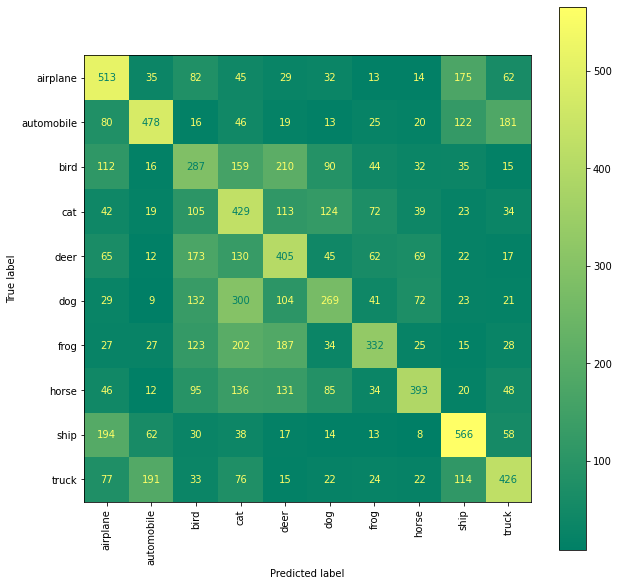

X_train : (700, 32, 32, 3)
y train : (700, 1)
X val : (300, 32, 32, 3)
y val: (300, 1)
Epoch 1/50
22/22 [==============================] - 2s 85ms/step - loss: 2.3313 - accuracy: 0.1200 - val_loss: 2.3020 - val_accuracy: 0.0933
Epoch 2/50
22/22 [==============================] - 2s 81ms/step - loss: 2.2901 - accuracy: 0.1286 - val_loss: 2.2093 - val_accuracy: 0.1600
Epoch 3/50
22/22 [==============================] - 2s 78ms/step - loss: 2.1739 - accuracy: 0.1757 - val_loss: 2.1573 - val_accuracy: 0.1867
Epoch 4/50
22/22 [==============================] - 2s 110ms/step - loss: 2.0937 - accuracy: 0.1957 - val_loss: 2.0521 - val_accuracy: 0.2000
Epoch 5/50
22/22 [==============================] - 2s 113ms/step - loss: 2.0284 - accuracy: 0.2571 - val_loss: 2.1444 - val_accuracy: 0.2467
Epoch 6/50
22/22 [==============================] - 2s 113ms/step - loss: 1.9186 - accuracy: 0.2843 - val_loss: 1.9796 - val_accuracy: 0.2267
Epoch 7/50
22/22 [==============================] - 2s 109ms/ste

<Figure size 432x288 with 0 Axes>

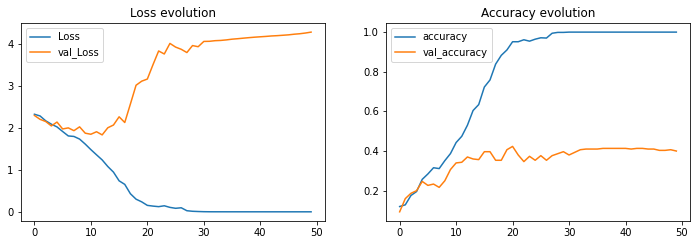

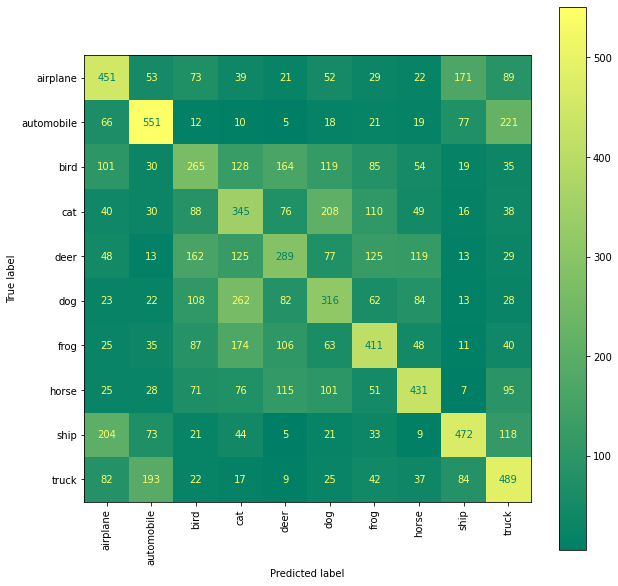

After selecting samples based on Samping methods on round 1  :
Train :  (2000, 32, 32, 3) (2000, 1)
Seedset  :  (48000, 32, 32, 3) (48000, 1)
Unique(labels): [181 191 193 214 195 245 204 196 185 196] [0 1 2 3 4 5 6 7 8 9]
-------Round  2 ----------------
Model 1 training
X_train : (1400, 32, 32, 3)
y train : (1400, 1)
X val : (600, 32, 32, 3)
y val: (600, 1)
Epoch 1/50
44/44 [==============================] - 3s 67ms/step - loss: 2.3140 - accuracy: 0.1136 - val_loss: 2.2815 - val_accuracy: 0.1667
Epoch 2/50
44/44 [==============================] - 3s 67ms/step - loss: 2.1817 - accuracy: 0.1914 - val_loss: 2.0978 - val_accuracy: 0.2000
Epoch 3/50
44/44 [==============================] - 3s 64ms/step - loss: 2.0825 - accuracy: 0.2100 - val_loss: 2.0690 - val_accuracy: 0.2133
Epoch 4/50
44/44 [==============================] - 3s 63ms/step - loss: 2.0029 - accuracy: 0.2536 - val_loss: 1.9112 - val_accuracy: 0.2450
Epoch 5/50
44/44 [==============================] - 3s 65ms/step - loss: 1.

<Figure size 432x288 with 0 Axes>

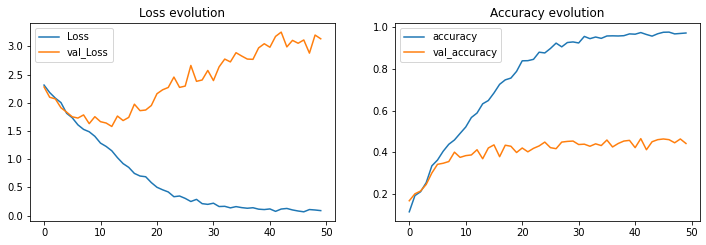

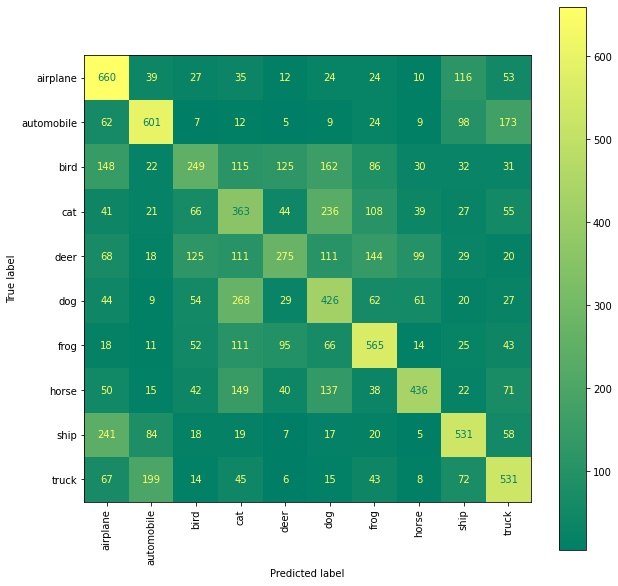

Model 2 training
X_train : (1400, 32, 32, 3)
y train : (1400, 1)
X val : (600, 32, 32, 3)
y val: (600, 1)
Epoch 1/50
44/44 [==============================] - 5s 117ms/step - loss: 2.3120 - accuracy: 0.1179 - val_loss: 2.3019 - val_accuracy: 0.1150
Epoch 2/50
44/44 [==============================] - 5s 107ms/step - loss: 2.2996 - accuracy: 0.1257 - val_loss: 2.2682 - val_accuracy: 0.1150
Epoch 3/50
44/44 [==============================] - 5s 108ms/step - loss: 2.2477 - accuracy: 0.1350 - val_loss: 2.1898 - val_accuracy: 0.1467
Epoch 4/50
44/44 [==============================] - 5s 110ms/step - loss: 2.0992 - accuracy: 0.1900 - val_loss: 1.9874 - val_accuracy: 0.2283
Epoch 5/50
44/44 [==============================] - 5s 108ms/step - loss: 1.9756 - accuracy: 0.2329 - val_loss: 2.0223 - val_accuracy: 0.2067
Epoch 6/50
44/44 [==============================] - 5s 112ms/step - loss: 1.8806 - accuracy: 0.2579 - val_loss: 1.8054 - val_accuracy: 0.2783
Epoch 7/50
44/44 [========================

<Figure size 432x288 with 0 Axes>

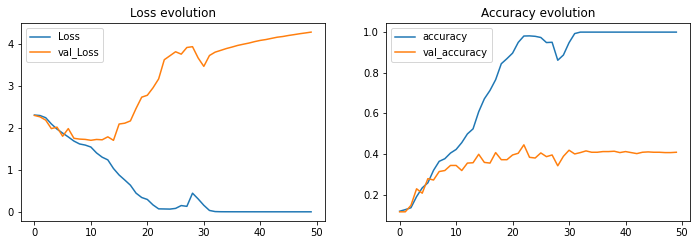

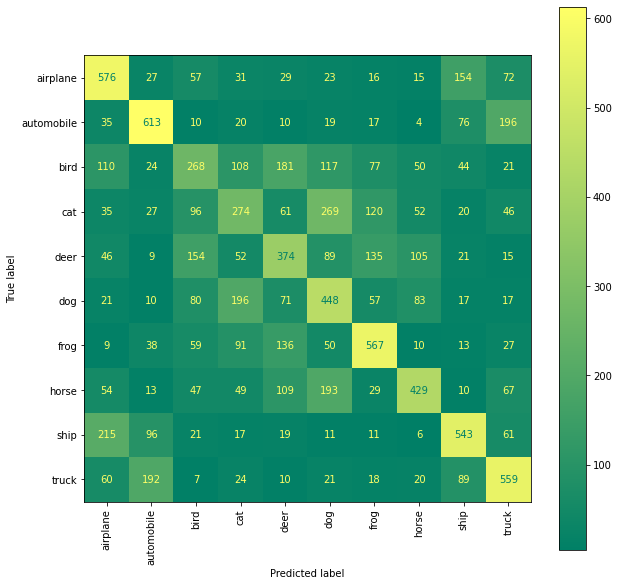

After selecting samples based on Samping methods on round 2  :
Train :  (3000, 32, 32, 3) (3000, 1)
Seedset  :  (47000, 32, 32, 3) (47000, 1)
Unique(labels): [256 266 311 331 335 356 273 306 267 299] [0 1 2 3 4 5 6 7 8 9]
-------Finish training anthor 1000 samples on round  2 ----------------
-------Round  3 ----------------
Model 1 training
X_train : (2100, 32, 32, 3)
y train : (2100, 1)
X val : (900, 32, 32, 3)
y val: (900, 1)
Epoch 1/50
66/66 [==============================] - 5s 69ms/step - loss: 2.2742 - accuracy: 0.1219 - val_loss: 2.0960 - val_accuracy: 0.2122
Epoch 2/50
66/66 [==============================] - 4s 66ms/step - loss: 2.1002 - accuracy: 0.2057 - val_loss: 1.9479 - val_accuracy: 0.2744
Epoch 3/50
66/66 [==============================] - 5s 69ms/step - loss: 1.9230 - accuracy: 0.2733 - val_loss: 1.8552 - val_accuracy: 0.3033
Epoch 4/50
66/66 [==============================] - 5s 70ms/step - loss: 1.8234 - accuracy: 0.3052 - val_loss: 1.7824 - val_accuracy: 0.3378
Epo

<Figure size 432x288 with 0 Axes>

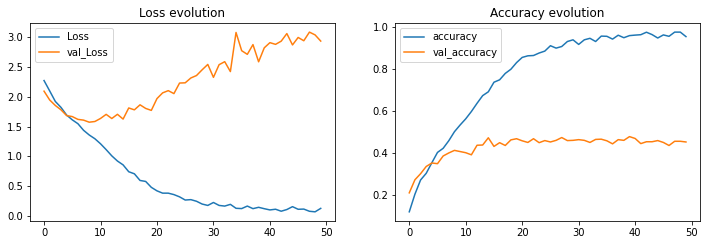

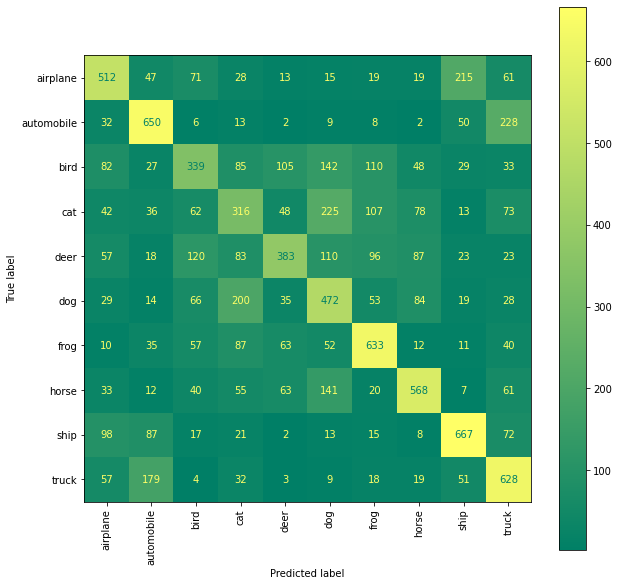

Model 2 training
X_train : (2100, 32, 32, 3)
y train : (2100, 1)
X val : (900, 32, 32, 3)
y val: (900, 1)
Epoch 1/50
66/66 [==============================] - 7s 101ms/step - loss: 2.2425 - accuracy: 0.1329 - val_loss: 2.0654 - val_accuracy: 0.1900
Epoch 2/50
66/66 [==============================] - 7s 113ms/step - loss: 2.0074 - accuracy: 0.1924 - val_loss: 1.9585 - val_accuracy: 0.2333
Epoch 3/50
66/66 [==============================] - 7s 101ms/step - loss: 1.9146 - accuracy: 0.2500 - val_loss: 1.8690 - val_accuracy: 0.2811
Epoch 4/50
66/66 [==============================] - 7s 101ms/step - loss: 1.8892 - accuracy: 0.2681 - val_loss: 1.8204 - val_accuracy: 0.2878
Epoch 5/50
66/66 [==============================] - 6s 97ms/step - loss: 1.7412 - accuracy: 0.3281 - val_loss: 1.8193 - val_accuracy: 0.2922
Epoch 6/50
66/66 [==============================] - 7s 110ms/step - loss: 1.6543 - accuracy: 0.3586 - val_loss: 1.7572 - val_accuracy: 0.3500
Epoch 7/50
66/66 [=========================

<Figure size 432x288 with 0 Axes>

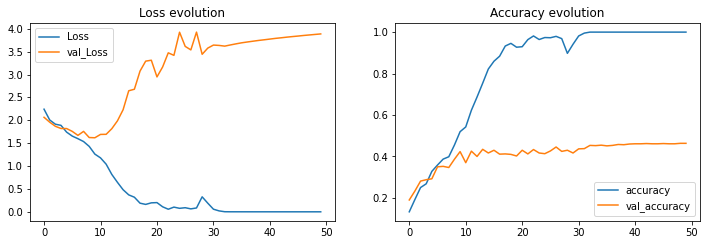

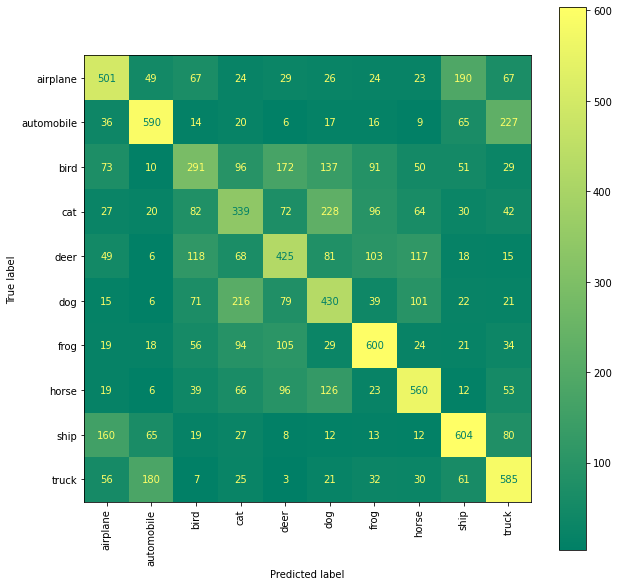

After selecting samples based on Samping methods on round 3  :
Train :  (4000, 32, 32, 3) (4000, 1)
Seedset  :  (46000, 32, 32, 3) (46000, 1)
Unique(labels): [364 348 430 461 423 467 380 387 337 403] [0 1 2 3 4 5 6 7 8 9]
-------Finish training anthor 1000 samples on round  3 ----------------
-------Round  4 ----------------
Model 1 training
X_train : (2800, 32, 32, 3)
y train : (2800, 1)
X val : (1200, 32, 32, 3)
y val: (1200, 1)
Epoch 1/50
88/88 [==============================] - 6s 66ms/step - loss: 2.2522 - accuracy: 0.1400 - val_loss: 2.1072 - val_accuracy: 0.1858
Epoch 2/50
88/88 [==============================] - 6s 63ms/step - loss: 2.0688 - accuracy: 0.2064 - val_loss: 1.9491 - val_accuracy: 0.2575
Epoch 3/50
88/88 [==============================] - 6s 64ms/step - loss: 1.8981 - accuracy: 0.2796 - val_loss: 1.8961 - val_accuracy: 0.2717
Epoch 4/50
88/88 [==============================] - 6s 66ms/step - loss: 1.7937 - accuracy: 0.3214 - val_loss: 1.7170 - val_accuracy: 0.3450
E

<Figure size 432x288 with 0 Axes>

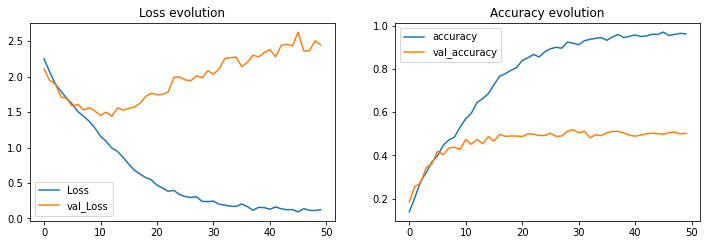

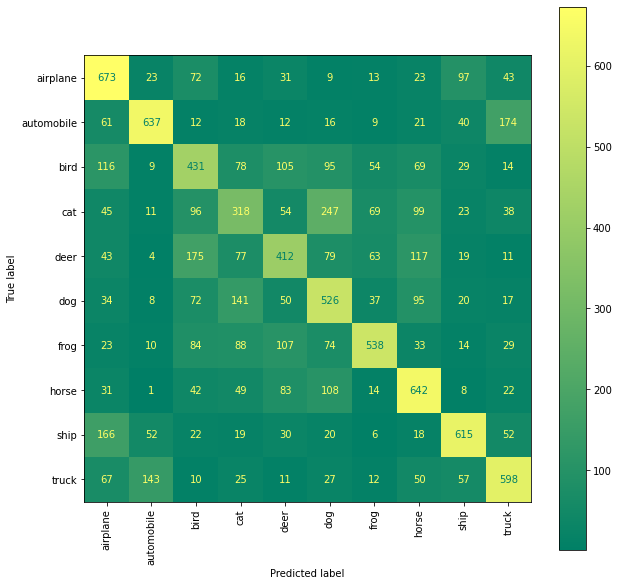

Model 2 training
X_train : (2800, 32, 32, 3)
y train : (2800, 1)
X val : (1200, 32, 32, 3)
y val: (1200, 1)
Epoch 1/50
88/88 [==============================] - 9s 98ms/step - loss: 2.2442 - accuracy: 0.1468 - val_loss: 2.1499 - val_accuracy: 0.1667
Epoch 2/50
88/88 [==============================] - 9s 104ms/step - loss: 2.0819 - accuracy: 0.2021 - val_loss: 2.0423 - val_accuracy: 0.1833
Epoch 3/50
88/88 [==============================] - 9s 105ms/step - loss: 1.9292 - accuracy: 0.2543 - val_loss: 1.8086 - val_accuracy: 0.3175
Epoch 4/50
88/88 [==============================] - 9s 107ms/step - loss: 1.8375 - accuracy: 0.2782 - val_loss: 1.8253 - val_accuracy: 0.3075
Epoch 5/50
88/88 [==============================] - 9s 102ms/step - loss: 1.7103 - accuracy: 0.3368 - val_loss: 1.7004 - val_accuracy: 0.3558
Epoch 6/50
88/88 [==============================] - 9s 99ms/step - loss: 1.6569 - accuracy: 0.3711 - val_loss: 1.6774 - val_accuracy: 0.3417
Epoch 7/50
88/88 [========================

<Figure size 432x288 with 0 Axes>

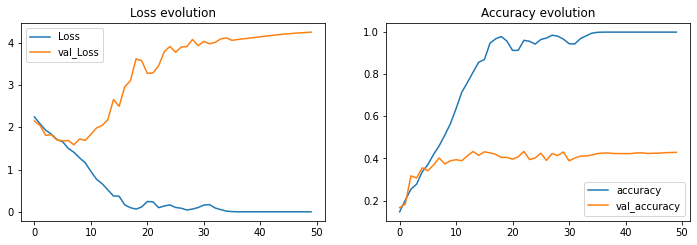

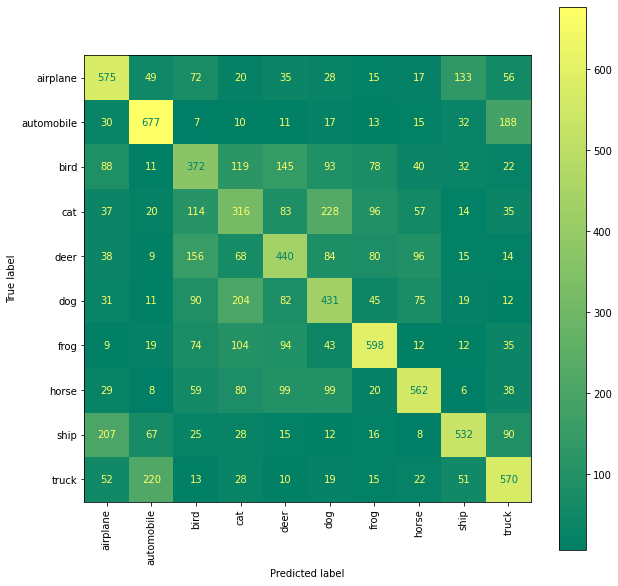

After selecting samples based on Samping methods on round 4  :
Train :  (5000, 32, 32, 3) (5000, 1)
Seedset  :  (45000, 32, 32, 3) (45000, 1)
Unique(labels): [450 445 551 569 520 584 476 484 437 484] [0 1 2 3 4 5 6 7 8 9]
-------Finish training anthor 1000 samples on round  4 ----------------
-------Round  5 ----------------
Model 1 training
X_train : (3500, 32, 32, 3)
y train : (3500, 1)
X val : (1500, 32, 32, 3)
y val: (1500, 1)
Epoch 1/50
110/110 [==============================] - 7s 65ms/step - loss: 2.1873 - accuracy: 0.1529 - val_loss: 1.9897 - val_accuracy: 0.2633
Epoch 2/50
110/110 [==============================] - 7s 63ms/step - loss: 1.9202 - accuracy: 0.2666 - val_loss: 1.8988 - val_accuracy: 0.2667
Epoch 3/50
110/110 [==============================] - 7s 61ms/step - loss: 1.8017 - accuracy: 0.3140 - val_loss: 1.7648 - val_accuracy: 0.3273
Epoch 4/50
110/110 [==============================] - 7s 67ms/step - loss: 1.7220 - accuracy: 0.3517 - val_loss: 1.6935 - val_accuracy: 

<Figure size 432x288 with 0 Axes>

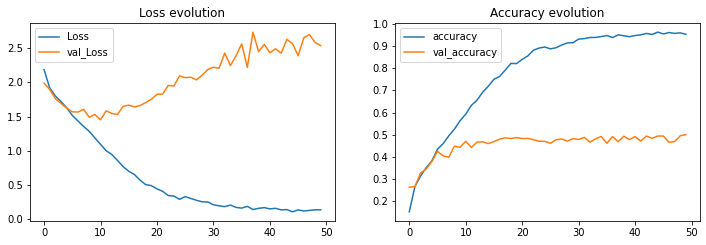

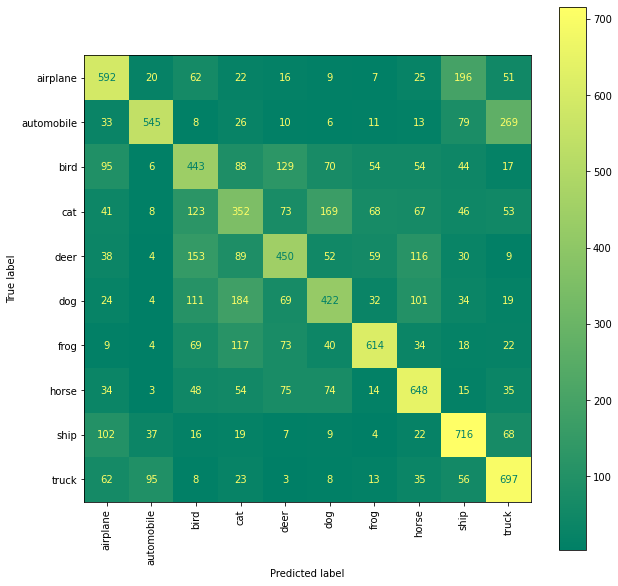

Model 2 training
X_train : (3500, 32, 32, 3)
y train : (3500, 1)
X val : (1500, 32, 32, 3)
y val: (1500, 1)
Epoch 1/50
110/110 [==============================] - 11s 102ms/step - loss: 2.1822 - accuracy: 0.1549 - val_loss: 2.0062 - val_accuracy: 0.2193
Epoch 2/50
110/110 [==============================] - 11s 104ms/step - loss: 1.9619 - accuracy: 0.2203 - val_loss: 1.9242 - val_accuracy: 0.2260
Epoch 3/50
110/110 [==============================] - 12s 113ms/step - loss: 1.8459 - accuracy: 0.2689 - val_loss: 1.9476 - val_accuracy: 0.2573
Epoch 4/50
110/110 [==============================] - 12s 113ms/step - loss: 1.7524 - accuracy: 0.3140 - val_loss: 1.7463 - val_accuracy: 0.3053
Epoch 5/50
110/110 [==============================] - 12s 113ms/step - loss: 1.6907 - accuracy: 0.3451 - val_loss: 1.6831 - val_accuracy: 0.3447
Epoch 6/50
110/110 [==============================] - 12s 114ms/step - loss: 1.5632 - accuracy: 0.3871 - val_loss: 1.6540 - val_accuracy: 0.3587
Epoch 7/50
110/110 [==

<Figure size 432x288 with 0 Axes>

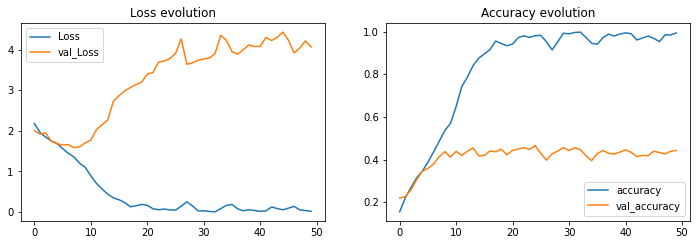

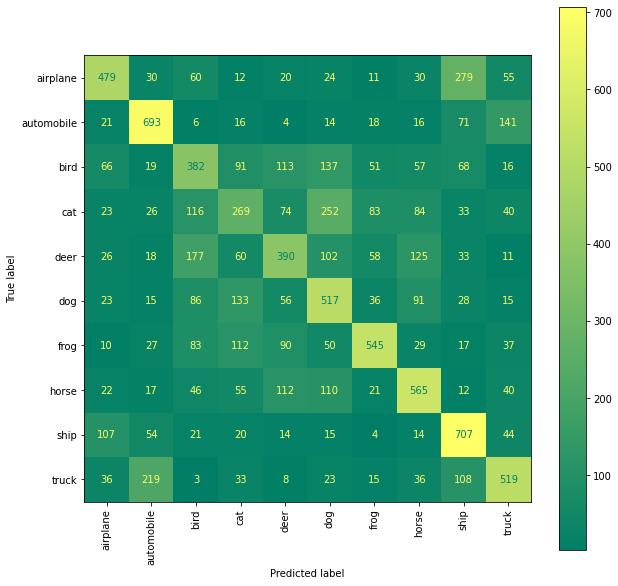

After selecting samples based on Samping methods on round 5  :
Train :  (6000, 32, 32, 3) (6000, 1)
Seedset  :  (44000, 32, 32, 3) (44000, 1)
Unique(labels): [556 537 651 697 634 694 584 567 507 573] [0 1 2 3 4 5 6 7 8 9]
-------Finish training anthor 1000 samples on round  5 ----------------
-------Round  6 ----------------
Model 1 training
X_train : (4200, 32, 32, 3)
y train : (4200, 1)
X val : (1800, 32, 32, 3)
y val: (1800, 1)
Epoch 1/50
132/132 [==============================] - 7s 57ms/step - loss: 2.1980 - accuracy: 0.1602 - val_loss: 1.9700 - val_accuracy: 0.2428
Epoch 2/50
132/132 [==============================] - 7s 54ms/step - loss: 1.9483 - accuracy: 0.2490 - val_loss: 1.8117 - val_accuracy: 0.3128
Epoch 3/50
132/132 [==============================] - 8s 59ms/step - loss: 1.8064 - accuracy: 0.3086 - val_loss: 1.7761 - val_accuracy: 0.3322
Epoch 4/50
132/132 [==============================] - 8s 61ms/step - loss: 1.6896 - accuracy: 0.3610 - val_loss: 1.6881 - val_accuracy: 

<Figure size 432x288 with 0 Axes>

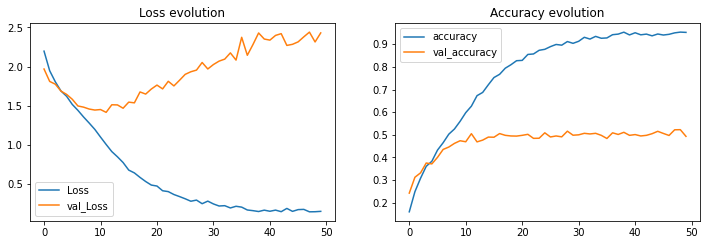

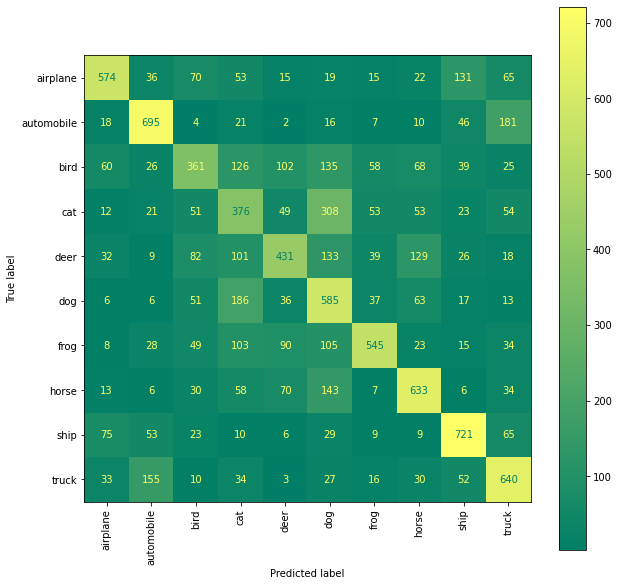

Model 2 training
X_train : (4200, 32, 32, 3)
y train : (4200, 1)
X val : (1800, 32, 32, 3)
y val: (1800, 1)
Epoch 1/50
132/132 [==============================] - 14s 107ms/step - loss: 2.2093 - accuracy: 0.1421 - val_loss: 2.0329 - val_accuracy: 0.1761
Epoch 2/50
132/132 [==============================] - 13s 100ms/step - loss: 1.9857 - accuracy: 0.2124 - val_loss: 1.8489 - val_accuracy: 0.2706
Epoch 3/50
132/132 [==============================] - 14s 105ms/step - loss: 1.8592 - accuracy: 0.2888 - val_loss: 1.8406 - val_accuracy: 0.3022
Epoch 4/50
132/132 [==============================] - 15s 111ms/step - loss: 1.7684 - accuracy: 0.3188 - val_loss: 1.6901 - val_accuracy: 0.3711
Epoch 5/50
132/132 [==============================] - 15s 115ms/step - loss: 1.6810 - accuracy: 0.3638 - val_loss: 1.6708 - val_accuracy: 0.3650
Epoch 6/50
132/132 [==============================] - 15s 111ms/step - loss: 1.5722 - accuracy: 0.3995 - val_loss: 1.5532 - val_accuracy: 0.3983
Epoch 7/50
132/132 [==

<Figure size 432x288 with 0 Axes>

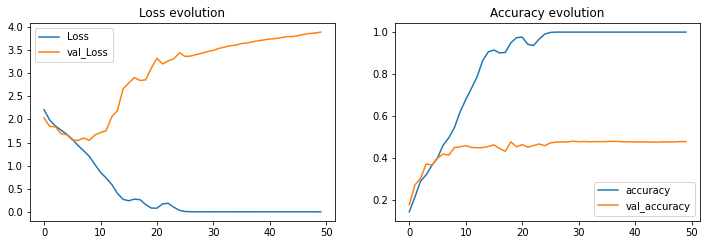

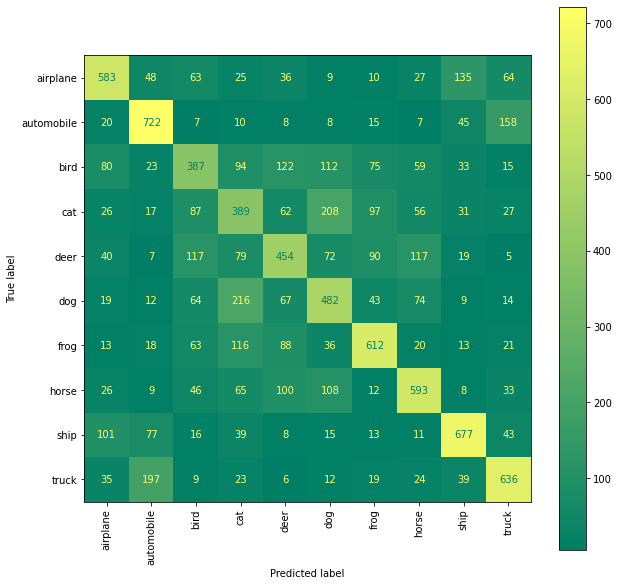

After selecting samples based on Samping methods on round 6  :
Train :  (7000, 32, 32, 3) (7000, 1)
Seedset  :  (43000, 32, 32, 3) (43000, 1)
Unique(labels): [639 612 797 815 742 795 682 662 594 662] [0 1 2 3 4 5 6 7 8 9]
-------Finish training anthor 1000 samples on round  6 ----------------
-------Round  7 ----------------
Model 1 training
X_train : (4900, 32, 32, 3)
y train : (4900, 1)
X val : (2100, 32, 32, 3)
y val: (2100, 1)
Epoch 1/50
154/154 [==============================] - 10s 65ms/step - loss: 2.2149 - accuracy: 0.1535 - val_loss: 2.0756 - val_accuracy: 0.2276
Epoch 2/50
154/154 [==============================] - 10s 63ms/step - loss: 1.9660 - accuracy: 0.2518 - val_loss: 2.1671 - val_accuracy: 0.2238
Epoch 3/50
154/154 [==============================] - 9s 61ms/step - loss: 1.7965 - accuracy: 0.3237 - val_loss: 1.7303 - val_accuracy: 0.3438
Epoch 4/50
154/154 [==============================] - 10s 63ms/step - loss: 1.6712 - accuracy: 0.3663 - val_loss: 1.7165 - val_accurac

<Figure size 432x288 with 0 Axes>

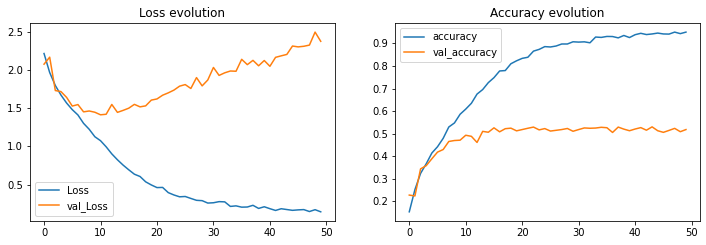

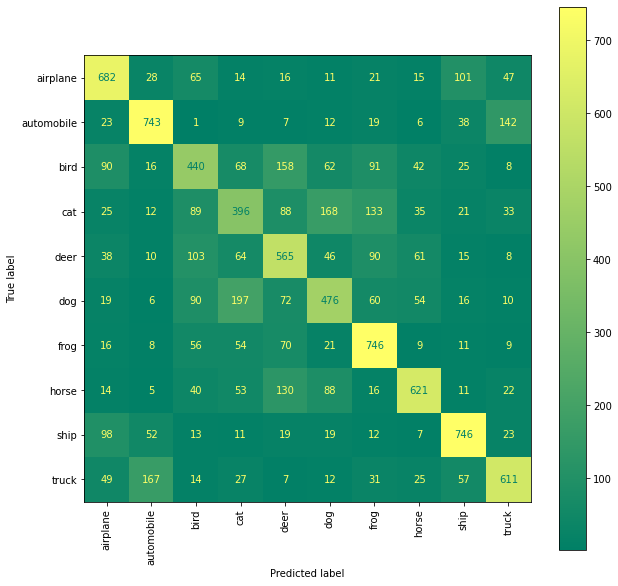

Model 2 training
X_train : (4900, 32, 32, 3)
y train : (4900, 1)
X val : (2100, 32, 32, 3)
y val: (2100, 1)
Epoch 1/50
154/154 [==============================] - 16s 102ms/step - loss: 2.2110 - accuracy: 0.1590 - val_loss: 2.1109 - val_accuracy: 0.1771
Epoch 2/50
154/154 [==============================] - 16s 105ms/step - loss: 2.0163 - accuracy: 0.2092 - val_loss: 1.9604 - val_accuracy: 0.2205
Epoch 3/50
154/154 [==============================] - 17s 111ms/step - loss: 1.8786 - accuracy: 0.2751 - val_loss: 1.9041 - val_accuracy: 0.2690
Epoch 4/50
154/154 [==============================] - 17s 112ms/step - loss: 1.7618 - accuracy: 0.3114 - val_loss: 1.7012 - val_accuracy: 0.3243
Epoch 5/50
154/154 [==============================] - 17s 111ms/step - loss: 1.6601 - accuracy: 0.3616 - val_loss: 1.7362 - val_accuracy: 0.3195
Epoch 6/50
154/154 [==============================] - 17s 113ms/step - loss: 1.6022 - accuracy: 0.3865 - val_loss: 1.6586 - val_accuracy: 0.3629
Epoch 7/50
154/154 [==

<Figure size 432x288 with 0 Axes>

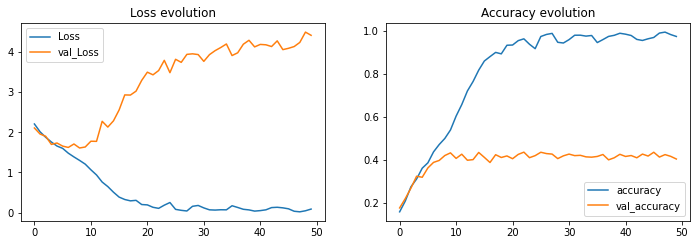

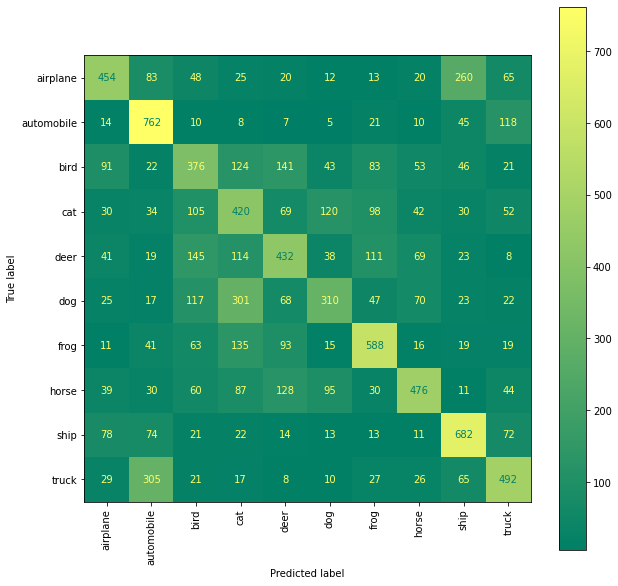

After selecting samples based on Samping methods on round 7  :
Train :  (8000, 32, 32, 3) (8000, 1)
Seedset  :  (42000, 32, 32, 3) (42000, 1)
Unique(labels): [744 669 892 930 865 922 769 775 667 767] [0 1 2 3 4 5 6 7 8 9]
-------Finish training anthor 1000 samples on round  7 ----------------
-------Round  8 ----------------
Model 1 training
X_train : (5600, 32, 32, 3)
y train : (5600, 1)
X val : (2400, 32, 32, 3)
y val: (2400, 1)
Epoch 1/50
175/175 [==============================] - 11s 63ms/step - loss: 2.1164 - accuracy: 0.1946 - val_loss: 1.8779 - val_accuracy: 0.2988
Epoch 2/50
175/175 [==============================] - 11s 62ms/step - loss: 1.8463 - accuracy: 0.2925 - val_loss: 1.7438 - val_accuracy: 0.3258
Epoch 3/50
175/175 [==============================] - 11s 61ms/step - loss: 1.7447 - accuracy: 0.3354 - val_loss: 1.7152 - val_accuracy: 0.3571
Epoch 4/50
175/175 [==============================] - 12s 68ms/step - loss: 1.6235 - accuracy: 0.3900 - val_loss: 1.6547 - val_accura

<Figure size 432x288 with 0 Axes>

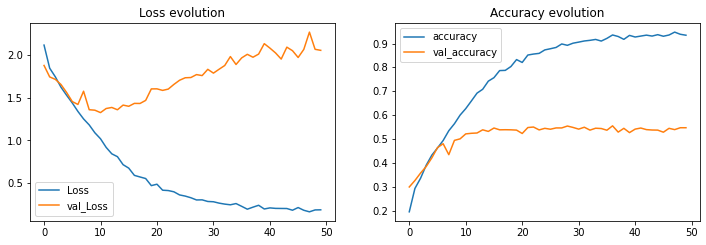

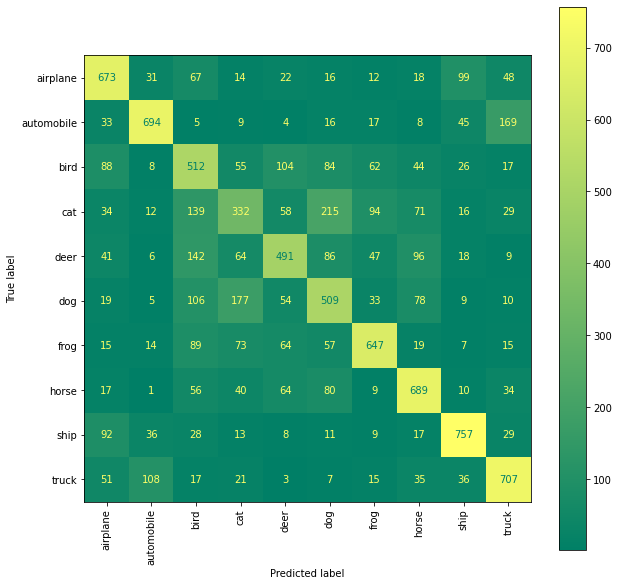

Model 2 training
X_train : (5600, 32, 32, 3)
y train : (5600, 1)
X val : (2400, 32, 32, 3)
y val: (2400, 1)
Epoch 1/50
175/175 [==============================] - 18s 103ms/step - loss: 2.1716 - accuracy: 0.1621 - val_loss: 2.0176 - val_accuracy: 0.1979
Epoch 2/50
175/175 [==============================] - 19s 109ms/step - loss: 1.9239 - accuracy: 0.2427 - val_loss: 1.9281 - val_accuracy: 0.2767
Epoch 3/50
175/175 [==============================] - 22s 123ms/step - loss: 1.8014 - accuracy: 0.3059 - val_loss: 1.7369 - val_accuracy: 0.3296
Epoch 4/50
175/175 [==============================] - 21s 122ms/step - loss: 1.6817 - accuracy: 0.3507 - val_loss: 1.6385 - val_accuracy: 0.3650
Epoch 5/50
175/175 [==============================] - 21s 118ms/step - loss: 1.5941 - accuracy: 0.3836 - val_loss: 1.6530 - val_accuracy: 0.3708
Epoch 6/50
175/175 [==============================] - 21s 121ms/step - loss: 1.4848 - accuracy: 0.4300 - val_loss: 1.5595 - val_accuracy: 0.4308
Epoch 7/50
175/175 [==

<Figure size 432x288 with 0 Axes>

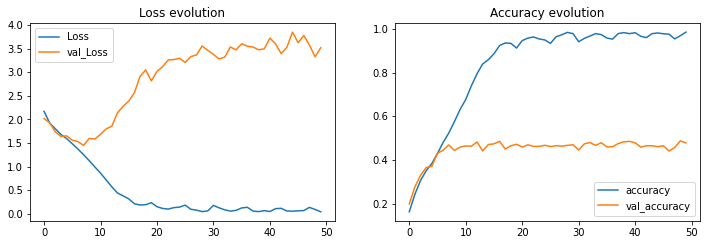

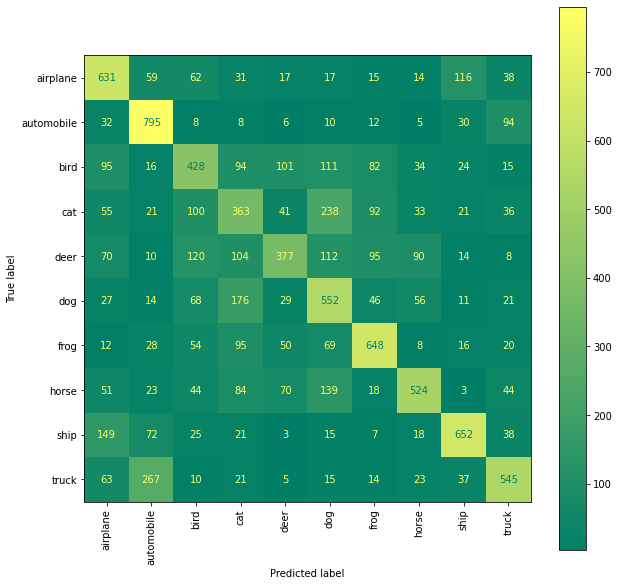

After selecting samples based on Samping methods on round 8  :
Train :  (9000, 32, 32, 3) (9000, 1)
Seedset  :  (41000, 32, 32, 3) (41000, 1)
Unique(labels): [ 829  750  997 1060  986 1016  857  868  755  882] [0 1 2 3 4 5 6 7 8 9]
-------Finish training anthor 1000 samples on round  8 ----------------
-------Round  9 ----------------
Model 1 training
X_train : (6300, 32, 32, 3)
y train : (6300, 1)
X val : (2700, 32, 32, 3)
y val: (2700, 1)
Epoch 1/50
197/197 [==============================] - 13s 64ms/step - loss: 2.1170 - accuracy: 0.1949 - val_loss: 1.9634 - val_accuracy: 0.2730
Epoch 2/50
197/197 [==============================] - 12s 63ms/step - loss: 1.8332 - accuracy: 0.3071 - val_loss: 1.7657 - val_accuracy: 0.3374
Epoch 3/50
197/197 [==============================] - 13s 67ms/step - loss: 1.6916 - accuracy: 0.3637 - val_loss: 1.6361 - val_accuracy: 0.3922
Epoch 4/50
197/197 [==============================] - 14s 69ms/step - loss: 1.6100 - accuracy: 0.3963 - val_loss: 1.6138 - 

<Figure size 432x288 with 0 Axes>

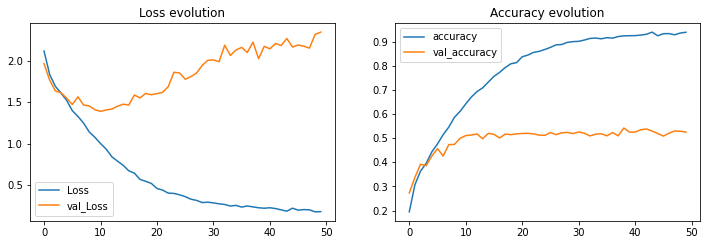

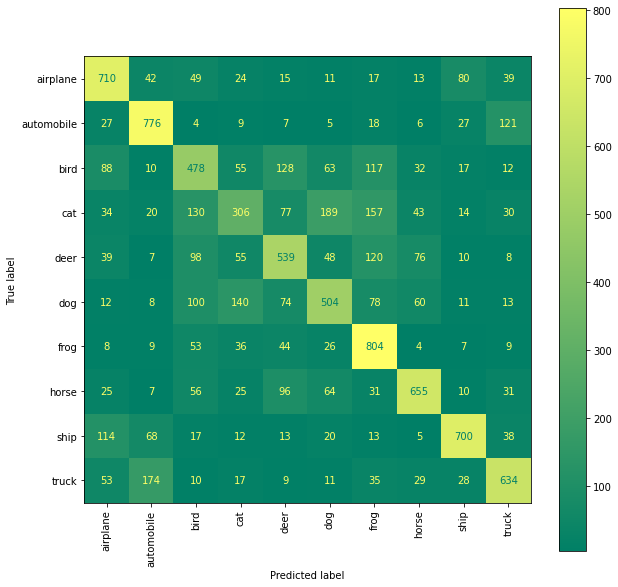

Model 2 training
X_train : (6300, 32, 32, 3)
y train : (6300, 1)
X val : (2700, 32, 32, 3)
y val: (2700, 1)
Epoch 1/50
197/197 [==============================] - 20s 103ms/step - loss: 2.1566 - accuracy: 0.1652 - val_loss: 2.1034 - val_accuracy: 0.2244
Epoch 2/50
197/197 [==============================] - 22s 111ms/step - loss: 1.9601 - accuracy: 0.2398 - val_loss: 1.8421 - val_accuracy: 0.2848
Epoch 3/50
197/197 [==============================] - 22s 113ms/step - loss: 1.7848 - accuracy: 0.3162 - val_loss: 1.8865 - val_accuracy: 0.2952
Epoch 4/50
197/197 [==============================] - 22s 112ms/step - loss: 1.6659 - accuracy: 0.3617 - val_loss: 1.6262 - val_accuracy: 0.3822
Epoch 5/50
197/197 [==============================] - 22s 113ms/step - loss: 1.5388 - accuracy: 0.4110 - val_loss: 1.5741 - val_accuracy: 0.3959
Epoch 6/50
197/197 [==============================] - 22s 114ms/step - loss: 1.4238 - accuracy: 0.4668 - val_loss: 1.5865 - val_accuracy: 0.4093
Epoch 7/50
197/197 [==

<Figure size 432x288 with 0 Axes>

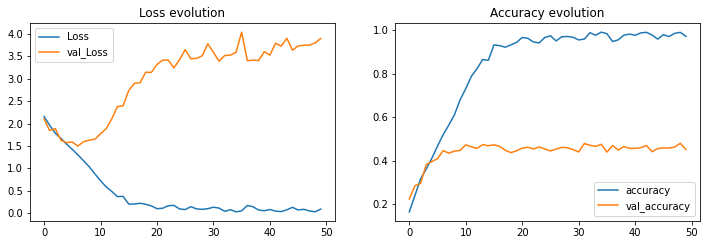

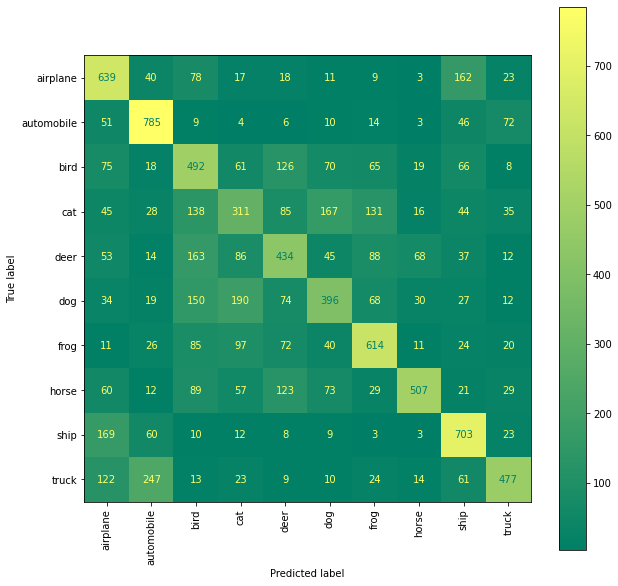

After selecting samples based on Samping methods on round 9  :
Train :  (10000, 32, 32, 3) (10000, 1)
Seedset  :  (40000, 32, 32, 3) (40000, 1)
Unique(labels): [ 930  831 1095 1183 1090 1152  936  966  834  983] [0 1 2 3 4 5 6 7 8 9]
-------Finish training anthor 1000 samples on round  9 ----------------
-------Round  10 ----------------
Model 1 training
X_train : (7000, 32, 32, 3)
y train : (7000, 1)
X val : (3000, 32, 32, 3)
y val: (3000, 1)
Epoch 1/50
219/219 [==============================] - 15s 67ms/step - loss: 2.1261 - accuracy: 0.1916 - val_loss: 1.9864 - val_accuracy: 0.2503
Epoch 2/50
219/219 [==============================] - 15s 68ms/step - loss: 1.8662 - accuracy: 0.2846 - val_loss: 1.7697 - val_accuracy: 0.3213
Epoch 3/50
219/219 [==============================] - 15s 70ms/step - loss: 1.7369 - accuracy: 0.3376 - val_loss: 1.6528 - val_accuracy: 0.3790
Epoch 4/50
219/219 [==============================] - 17s 76ms/step - loss: 1.6251 - accuracy: 0.3866 - val_loss: 1.5864

<Figure size 432x288 with 0 Axes>

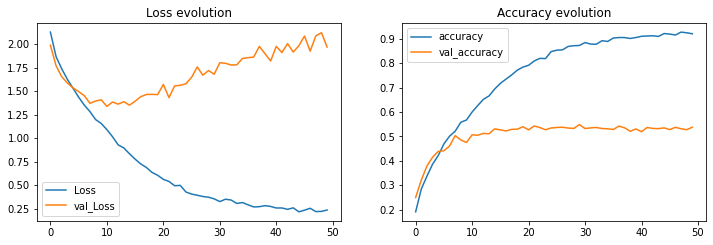

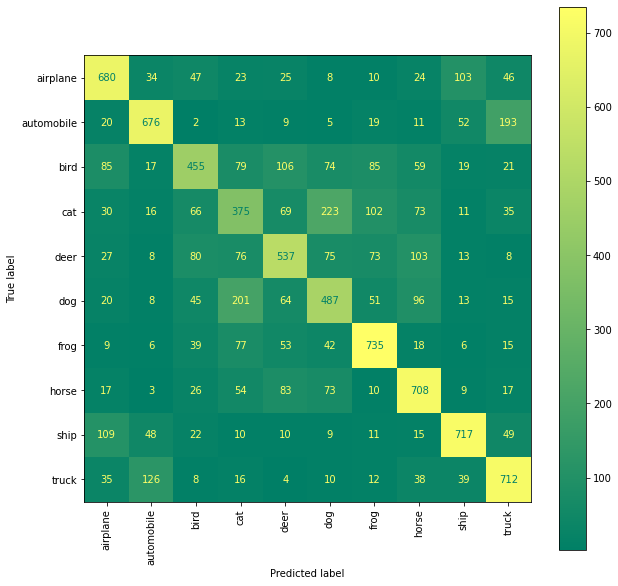

Model 2 training
X_train : (7000, 32, 32, 3)
y train : (7000, 1)
X val : (3000, 32, 32, 3)
y val: (3000, 1)
Epoch 1/50
219/219 [==============================] - 24s 109ms/step - loss: 2.3001 - accuracy: 0.1160 - val_loss: 2.2930 - val_accuracy: 0.1133
Epoch 2/50
219/219 [==============================] - 24s 109ms/step - loss: 2.2372 - accuracy: 0.1366 - val_loss: 2.1103 - val_accuracy: 0.1737
Epoch 3/50
219/219 [==============================] - 24s 109ms/step - loss: 1.9345 - accuracy: 0.2423 - val_loss: 1.8598 - val_accuracy: 0.2947
Epoch 4/50
219/219 [==============================] - 24s 110ms/step - loss: 1.7998 - accuracy: 0.3057 - val_loss: 1.7553 - val_accuracy: 0.3263
Epoch 5/50
219/219 [==============================] - 24s 111ms/step - loss: 1.7040 - accuracy: 0.3371 - val_loss: 1.7679 - val_accuracy: 0.3230
Epoch 6/50
219/219 [==============================] - 24s 110ms/step - loss: 1.6313 - accuracy: 0.3664 - val_loss: 1.6706 - val_accuracy: 0.3473
Epoch 7/50
219/219 [==

<Figure size 432x288 with 0 Axes>

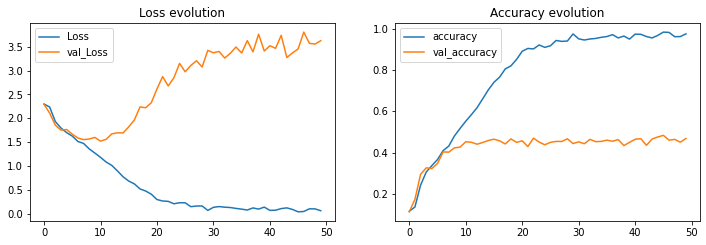

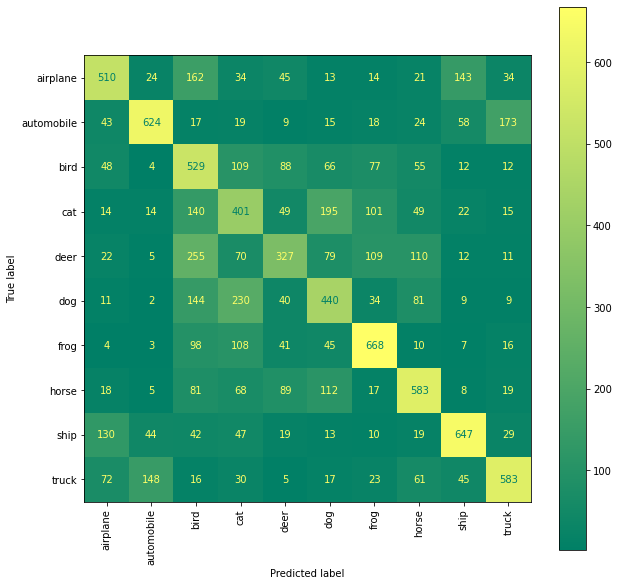

After selecting samples based on Samping methods on round 10  :
Train :  (11000, 32, 32, 3) (11000, 1)
Seedset  :  (39000, 32, 32, 3) (39000, 1)
Unique(labels): [1032  939 1201 1291 1216 1262 1004 1045  926 1084] [0 1 2 3 4 5 6 7 8 9]
-------Finish training anthor 1000 samples on round  10 ----------------
-------Round  11 ----------------
Model 1 training
X_train : (7700, 32, 32, 3)
y train : (7700, 1)
X val : (3300, 32, 32, 3)
y val: (3300, 1)
Epoch 1/50
241/241 [==============================] - 16s 68ms/step - loss: 2.0781 - accuracy: 0.2088 - val_loss: 1.8926 - val_accuracy: 0.2727
Epoch 2/50
241/241 [==============================] - 16s 68ms/step - loss: 1.7946 - accuracy: 0.3166 - val_loss: 1.7305 - val_accuracy: 0.3485
Epoch 3/50
241/241 [==============================] - 16s 67ms/step - loss: 1.6689 - accuracy: 0.3712 - val_loss: 1.6007 - val_accuracy: 0.3939
Epoch 4/50
241/241 [==============================] - 16s 67ms/step - loss: 1.5560 - accuracy: 0.4126 - val_loss: 1.52

<Figure size 432x288 with 0 Axes>

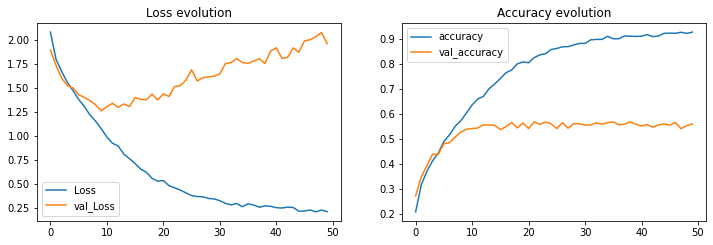

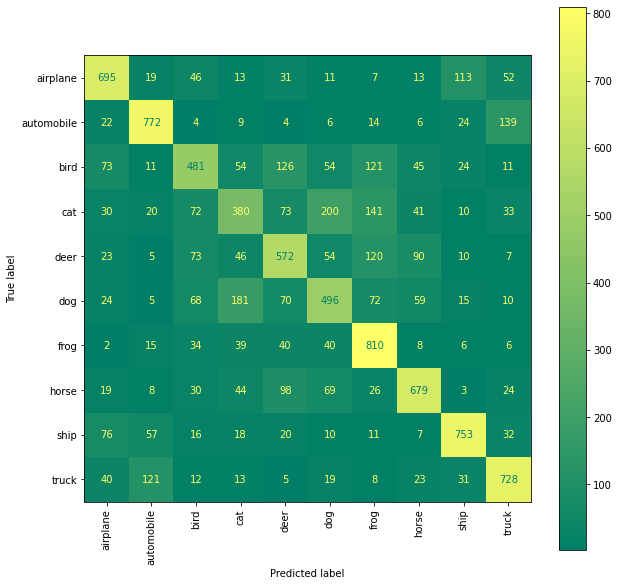

Model 2 training
X_train : (7700, 32, 32, 3)
y train : (7700, 1)
X val : (3300, 32, 32, 3)
y val: (3300, 1)
Epoch 1/50
241/241 [==============================] - 27s 112ms/step - loss: 2.1111 - accuracy: 0.1805 - val_loss: 1.8981 - val_accuracy: 0.2739
Epoch 2/50
241/241 [==============================] - 27s 112ms/step - loss: 1.8722 - accuracy: 0.2665 - val_loss: 1.8346 - val_accuracy: 0.2803
Epoch 3/50
241/241 [==============================] - 27s 112ms/step - loss: 1.7421 - accuracy: 0.3216 - val_loss: 1.7098 - val_accuracy: 0.3352
Epoch 4/50
241/241 [==============================] - 27s 112ms/step - loss: 1.6257 - accuracy: 0.3735 - val_loss: 1.6666 - val_accuracy: 0.3603
Epoch 5/50
241/241 [==============================] - 27s 112ms/step - loss: 1.5071 - accuracy: 0.4175 - val_loss: 1.6571 - val_accuracy: 0.3861
Epoch 6/50
241/241 [==============================] - 27s 112ms/step - loss: 1.3886 - accuracy: 0.4699 - val_loss: 1.5798 - val_accuracy: 0.4194
Epoch 7/50
241/241 [==

<Figure size 432x288 with 0 Axes>

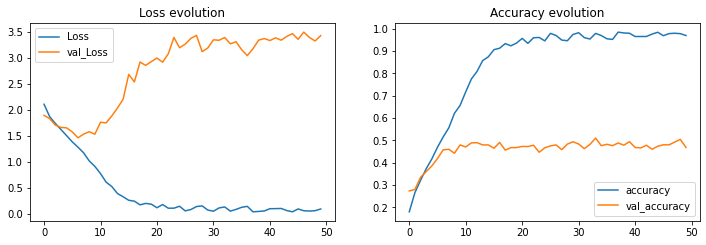

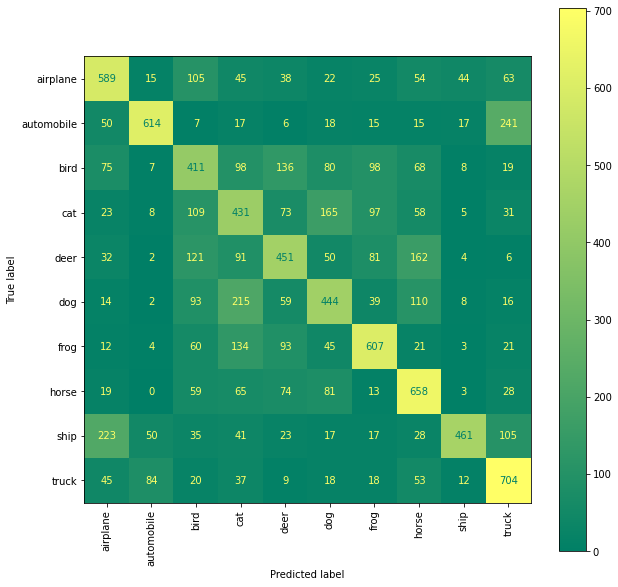

After selecting samples based on Samping methods on round 11  :
Train :  (12000, 32, 32, 3) (12000, 1)
Seedset  :  (38000, 32, 32, 3) (38000, 1)
Unique(labels): [1129 1034 1323 1407 1311 1370 1096 1110 1045 1175] [0 1 2 3 4 5 6 7 8 9]
-------Finish training anthor 1000 samples on round  11 ----------------
-------Round  12 ----------------
Model 1 training
X_train : (8400, 32, 32, 3)
y train : (8400, 1)
X val : (3600, 32, 32, 3)
y val: (3600, 1)
Epoch 1/50
263/263 [==============================] - 18s 68ms/step - loss: 2.0734 - accuracy: 0.2114 - val_loss: 1.8669 - val_accuracy: 0.2844
Epoch 2/50
263/263 [==============================] - 18s 68ms/step - loss: 1.7885 - accuracy: 0.3263 - val_loss: 1.6932 - val_accuracy: 0.3664
Epoch 3/50
263/263 [==============================] - 18s 68ms/step - loss: 1.6899 - accuracy: 0.3668 - val_loss: 1.6623 - val_accuracy: 0.3631
Epoch 4/50
263/263 [==============================] - 18s 68ms/step - loss: 1.5925 - accuracy: 0.4021 - val_loss: 1.58

<Figure size 432x288 with 0 Axes>

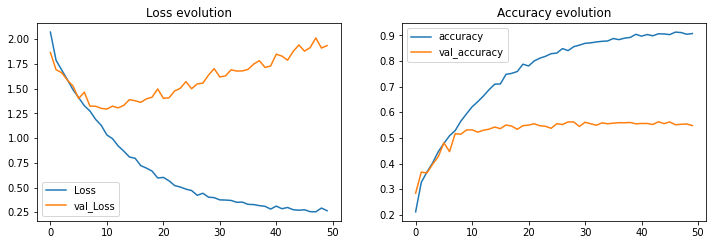

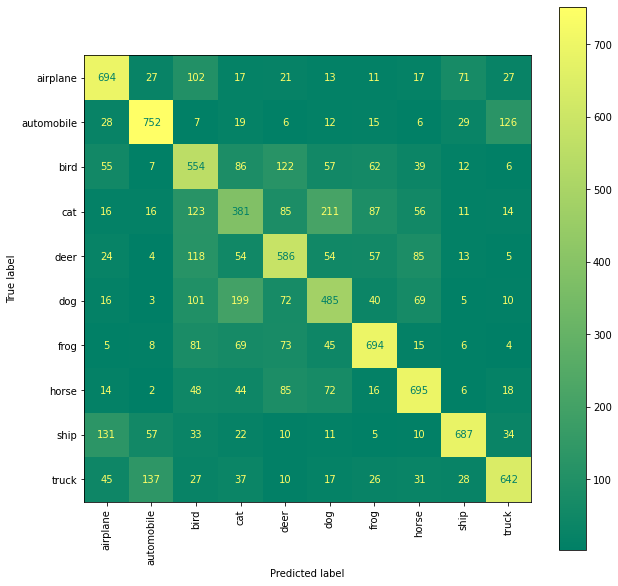

Model 2 training
X_train : (8400, 32, 32, 3)
y train : (8400, 1)
X val : (3600, 32, 32, 3)
y val: (3600, 1)
Epoch 1/50
263/263 [==============================] - 30s 113ms/step - loss: 2.1070 - accuracy: 0.1844 - val_loss: 1.9479 - val_accuracy: 0.2561
Epoch 2/50
263/263 [==============================] - 29s 112ms/step - loss: 1.8311 - accuracy: 0.2920 - val_loss: 1.7694 - val_accuracy: 0.3286
Epoch 3/50
263/263 [==============================] - 30s 113ms/step - loss: 1.6824 - accuracy: 0.3511 - val_loss: 1.6969 - val_accuracy: 0.3567
Epoch 4/50
263/263 [==============================] - 30s 112ms/step - loss: 1.5587 - accuracy: 0.4108 - val_loss: 1.5684 - val_accuracy: 0.4003
Epoch 5/50
263/263 [==============================] - 29s 112ms/step - loss: 1.4357 - accuracy: 0.4585 - val_loss: 1.6252 - val_accuracy: 0.3947
Epoch 6/50
263/263 [==============================] - 30s 112ms/step - loss: 1.3279 - accuracy: 0.4964 - val_loss: 1.4686 - val_accuracy: 0.4492
Epoch 7/50
263/263 [==

<Figure size 432x288 with 0 Axes>

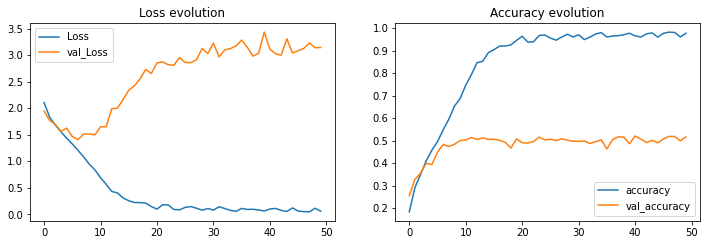

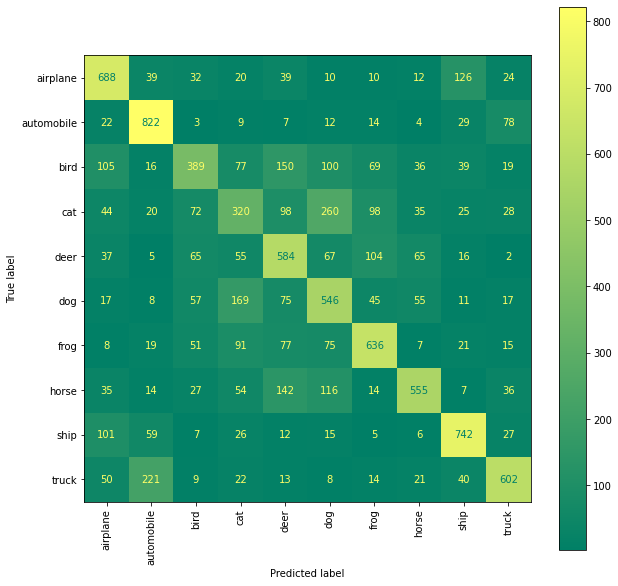

After selecting samples based on Samping methods on round 12  :
Train :  (13000, 32, 32, 3) (13000, 1)
Seedset  :  (37000, 32, 32, 3) (37000, 1)
Unique(labels): [1206 1098 1445 1530 1433 1488 1199 1199 1126 1276] [0 1 2 3 4 5 6 7 8 9]
-------Finish training anthor 1000 samples on round  12 ----------------
-------Round  13 ----------------
Model 1 training
X_train : (9100, 32, 32, 3)
y train : (9100, 1)
X val : (3900, 32, 32, 3)
y val: (3900, 1)
Epoch 1/50
285/285 [==============================] - 19s 67ms/step - loss: 2.0601 - accuracy: 0.2138 - val_loss: 1.8692 - val_accuracy: 0.2800
Epoch 2/50
285/285 [==============================] - 19s 68ms/step - loss: 1.8050 - accuracy: 0.3127 - val_loss: 1.7225 - val_accuracy: 0.3528
Epoch 3/50
285/285 [==============================] - 19s 67ms/step - loss: 1.6805 - accuracy: 0.3588 - val_loss: 1.6324 - val_accuracy: 0.4010
Epoch 4/50
285/285 [==============================] - 19s 68ms/step - loss: 1.5787 - accuracy: 0.4070 - val_loss: 1.52

<Figure size 432x288 with 0 Axes>

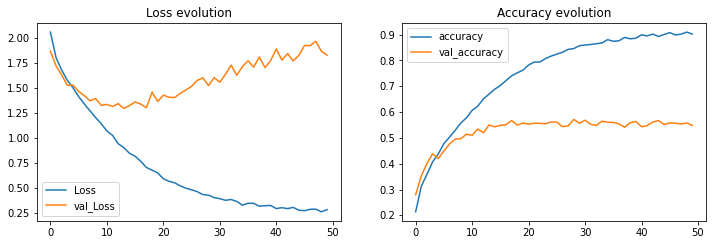

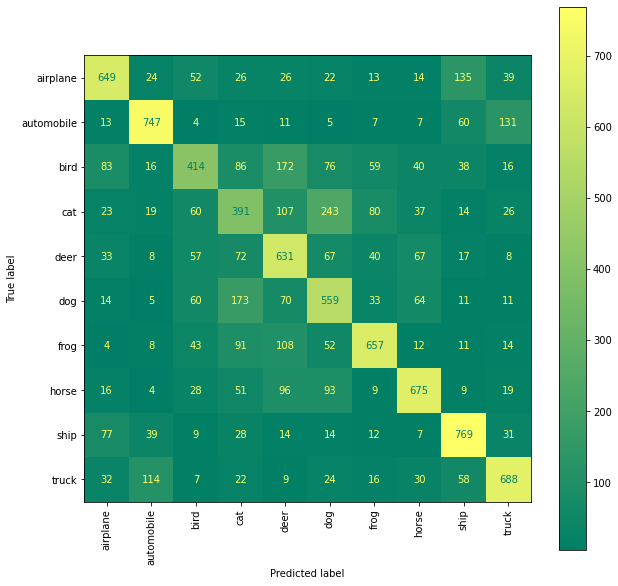

Model 2 training
X_train : (9100, 32, 32, 3)
y train : (9100, 1)
X val : (3900, 32, 32, 3)
y val: (3900, 1)
Epoch 1/50
285/285 [==============================] - 32s 113ms/step - loss: 2.0316 - accuracy: 0.2102 - val_loss: 1.8352 - val_accuracy: 0.2736
Epoch 2/50
285/285 [==============================] - 32s 112ms/step - loss: 1.8022 - accuracy: 0.3051 - val_loss: 1.7316 - val_accuracy: 0.3269
Epoch 3/50
285/285 [==============================] - 32s 112ms/step - loss: 1.6623 - accuracy: 0.3551 - val_loss: 1.6467 - val_accuracy: 0.3718
Epoch 4/50
285/285 [==============================] - 32s 111ms/step - loss: 1.5208 - accuracy: 0.4126 - val_loss: 1.5015 - val_accuracy: 0.4318
Epoch 5/50
285/285 [==============================] - 32s 112ms/step - loss: 1.3765 - accuracy: 0.4697 - val_loss: 1.5859 - val_accuracy: 0.3997
Epoch 6/50
285/285 [==============================] - 32s 112ms/step - loss: 1.2627 - accuracy: 0.5252 - val_loss: 1.4794 - val_accuracy: 0.4508
Epoch 7/50
285/285 [==

In [ ]:
labels= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

recordmodel1 = pd.DataFrame(columns=('TrainDS','Seedset', 'Train_Accuracy', 'Train_Loss', 'Val_Accuracy', 'Val_Loss', 'Test_Accuracy', 'Test_Loss' ))
recordmodel2 = pd.DataFrame(columns=('TrainDS','Seedset', 'Train_Accuracy', 'Train_Loss', 'Val_Accuracy', 'Val_Loss', 'Test_Accuracy', 'Test_Loss' ))

#get cifer dataset
X_train_full, y_train_full, X_test, y_test = get_dataset()

#get initial 1000 samples
permutation, X_train, y_train = get_k_random_samples(X_train_full.shape[0],1000, X_train_full, y_train_full)

print("Train set size X :",X_train.shape)
print(y_train.shape)

X_seedset = np.array([])
y_seedset = np.array([])
X_seedset = np.copy(X_train_full)
X_seedset = np.delete(X_seedset, permutation, axis=0)
y_seedset = np.copy(y_train_full)
y_seedset = np.delete(y_seedset, permutation, axis=0)
print ('Seed set (Pool) :', X_seedset.shape, y_seedset.shape)

#Normalize
normalizer = Normalize()
X_train, y_train = normalizer.normalize( X_train, y_train)
X_test, y_test = normalizer.normalize(X_test, y_test)
X_seedset, y_seedset = normalizer.normalize(X_seedset, y_seedset)

#train model
iterations = 0
probas_val1 = train_model1(X_train, y_train, X_seedset,X_test, y_test, labels)

probas_val2 = train_model2(X_train, y_train, X_seedset, X_test, y_test, labels)

#choose uncertain samples
#average KL
#selection_ranking = KL_QBC.average_KL_divergence(probas_val1, probas_val2,X_train, y_train, X_seedset, y_seedset)

#vote entropy
selection_ranking = vote_entropy_QBC.vote_entropy(probas_val1, probas_val2,X_train, y_train, X_seedset, y_seedset)

#random selection
#random_selection = RandomSelection.select(probas_val, 1000)



X_train = np.concatenate((X_train, X_seedset[selection_ranking, :]))
y_train = np.concatenate((y_train, y_seedset[selection_ranking]))

X_seedset = np.delete(X_seedset, selection_ranking, axis=0)
y_seedset = np.delete(y_seedset, selection_ranking, axis=0)

print('After selecting samples based on Samping methods on round',iterations+1,' :')
print('Train : ', X_train.shape, y_train.shape)
print('Seedset  : ', X_seedset.shape, y_seedset.shape)

y_train_bin = y_train.reshape((y_train.shape[0],))
bin_count = np.bincount(y_train_bin.astype('int64'))
unique = np.unique(y_train_bin.astype('int64'))
print ('Unique(labels):', bin_count, unique )

iterations = 1
while len(X_seedset) > 1 :
    print('-------Round ',iterations+1,'----------------')
    #normalize
    #   normalizer = Normalize()
    #   X_train, y_train = normalizer.normalize( X_train, y_train)
    #   X_test, y_test = normalizer.normalize(X_test, y_test)
    #   X_seedset, y_seedset = normalizer.normalize(X_seedset, y_seedset)

    #train
    print("Model 1 training")
    probas_val1 = train_model1(X_train, y_train, X_seedset,X_test, y_test, labels)
    print("Model 2 training")
    probas_val2 = train_model2(X_train, y_train, X_seedset, X_test, y_test, labels)


    #get uncertain examples
    #average KL
    #selection_ranking = KL_QBC.average_KL_divergence(probas_val1, probas_val2,X_train, y_train, X_seedset, y_seedset)
    #vote entropy
    selection_ranking = vote_entropy_QBC.vote_entropy(probas_val1, probas_val2,X_train, y_train, X_seedset, y_seedset)

    # normalization needs to be inversed and recalculated based on the new train and test set.
    #   X_train, y_train = normalizer.inverse(X_train, y_train)
    #   X_test, y_test = normalizer.inverse(X_test, y_test)
    #   X_seedset, y_seedset = normalizer.inverse(X_seedset, y_seedset)
    X_train = np.concatenate((X_train, X_seedset[selection_ranking, :]))
    y_train = np.concatenate((y_train, y_seedset[selection_ranking]))

    X_seedset = np.delete(X_seedset, selection_ranking, axis=0)
    y_seedset = np.delete(y_seedset, selection_ranking, axis=0)

    print('After selecting samples based on Samping methods on round',iterations+1,' :')
    print('Train : ', X_train.shape, y_train.shape)
    print('Seedset  : ', X_seedset.shape, y_seedset.shape)

    y_train_bin = y_train.reshape((y_train.shape[0],))
    bin_count = np.bincount(y_train_bin.astype('int64'))
    unique = np.unique(y_train_bin.astype('int64'))
    print ('Unique(labels):', bin_count, unique )

    print('-------Finish training anthor 1000 samples on round ',iterations+1,'----------------')
    iterations += 1
    